Seattle columns: ['STATION', 'NAME', 'DATE', 'DAPR', 'MDPR', 'PRCP', 'SNOW', 'SNWD', 'WESD', 'WESF']
St. Louis columns: ['STATION', 'NAME', 'DATE', 'DAPR', 'MDPR', 'PRCP', 'SNOW', 'SNWD']
New Orleans columns: ['STATION', 'NAME', 'DATE', 'PRCP', 'SNOW', 'SNWD']
Seattle: mean 36.60 -> converted to mm
St. Louis: mean 1243.73 -> assumed mm
New Orleans: mean 67.90 -> converted to mm


C:\Users\Asus\AppData\Local\Temp\ipykernel_18076\84752489.py:34: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df['DATE_parsed'] = pd.to_datetime(df['DATE'], errors='coerce', infer_datetime_format=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_18076\84752489.py:34: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['DATE_parsed'] = pd.to_datetime(df['DATE'], errors='coerce', infer_datetime_format=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_18076\84752489.py:34: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pyd

Saved plot to ..\Reports\yearly_comparison_neworleans.png


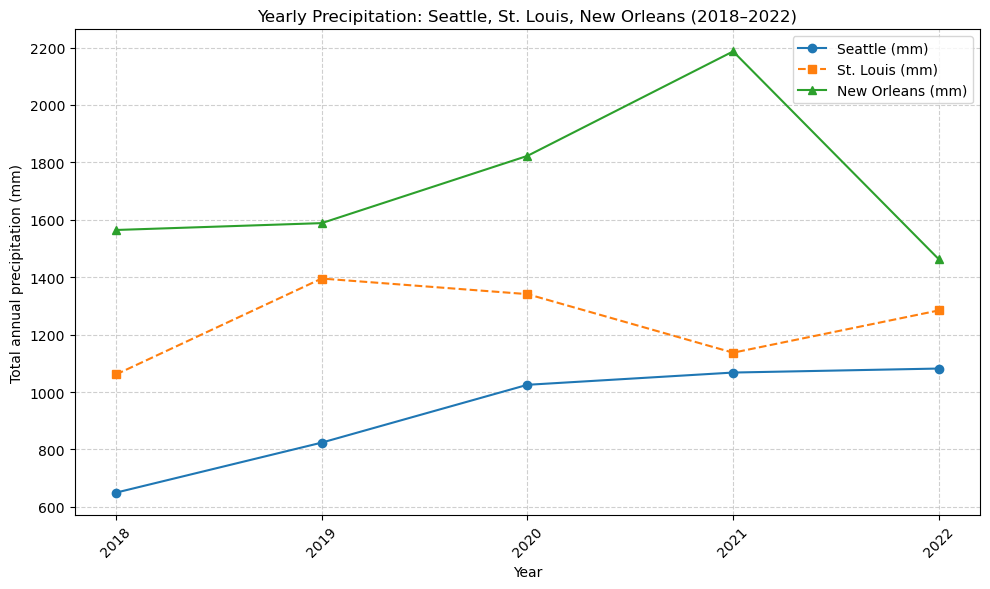

In [6]:
# === Load and prepare Seattle, St. Louis, New Orleans ===
import os, pandas as pd, matplotlib.pyplot as plt

data_dir = os.path.join("..","Data")  # notebook inside Code/
# Use exact filenames in your Data folder:
seattle_fp = os.path.join(data_dir, "seattle_rain.csv")
stl_fp     = os.path.join(data_dir, "stl_rain.csv")
# If NOAA file was .gz, change filename accordingly (e.g., neworleans_rain.csv.gz)
neworleans_fp = os.path.join(data_dir, "neworleans_rain.csv")  

# helper to safely read .csv or .csv.gz
def safe_read(fp):
    if not os.path.exists(fp):
        # try compressed .gz variant
        if os.path.exists(fp + ".gz"):
            fp = fp + ".gz"
        else:
            raise FileNotFoundError(f"File not found: {fp}")
    return pd.read_csv(fp)

seattle = safe_read(seattle_fp)
stl     = safe_read(stl_fp)
neworleans = safe_read(neworleans_fp)

# Quick column print to check names
print("Seattle columns:", list(seattle.columns))
print("St. Louis columns:", list(stl.columns))
print("New Orleans columns:", list(neworleans.columns))

# Parse dates and get Year
for df, name in [(seattle,'Seattle'), (stl,'St. Louis'), (neworleans,'New Orleans')]:
    # try common date columns
    if 'DATE' in df.columns:
        df['DATE_parsed'] = pd.to_datetime(df['DATE'], errors='coerce', infer_datetime_format=True)
    else:
        for alt in ['date','Date']:
            if alt in df.columns:
                df['DATE_parsed'] = pd.to_datetime(df[alt], errors='coerce', infer_datetime_format=True)
                break
    df['Year'] = df['DATE_parsed'].dt.year

# Find precipitation column (PRCP) robustly
def find_prcp_col(df):
    for c in df.columns:
        if c.strip().upper() in ('PRCP','PRECIP','PRECIPITATION'):
            return c
    # fallback: first numeric column that is not snow-related
    nums = df.select_dtypes(include='number').columns.tolist()
    for n in nums:
        if n.upper() not in ('SNOW','SNWD','WESD','WESF'):
            return n
    raise KeyError("No precipitation column found. Columns: " + ", ".join(df.columns))

sea_prcp = find_prcp_col(seattle)
stl_prcp = find_prcp_col(stl)
no_prcp  = find_prcp_col(neworleans)

# Compute yearly sums for 2018-2022
YEARS = [2018,2019,2020,2021,2022]
seattle_yearly = (seattle.dropna(subset=['Year']).groupby('Year')[sea_prcp].sum().reset_index().query("Year in @YEARS"))
stl_yearly     = (stl.dropna(subset=['Year']).groupby('Year')[stl_prcp].sum().reset_index().query("Year in @YEARS"))
no_yearly      = (neworleans.dropna(subset=['Year']).groupby('Year')[no_prcp].sum().reset_index().query("Year in @YEARS"))

# Convert to mm if necessary (heuristic)
def to_mm(df, col, city):
    meanv = df[col].mean()
    if pd.isna(meanv):
        raise ValueError(f"{city} {col} mean is NaN")
    if meanv < 100:  # likely inches
        df[col + "_mm"] = df[col] * 25.4
        print(f"{city}: mean {meanv:.2f} -> converted to mm")
    else:
        df[col + "_mm"] = df[col]
        print(f"{city}: mean {meanv:.2f} -> assumed mm")

to_mm(seattle_yearly, sea_prcp, "Seattle")
to_mm(stl_yearly, stl_prcp, "St. Louis")
to_mm(no_yearly, no_prcp, "New Orleans")

# Align years and plot
common_years = sorted(set(seattle_yearly['Year']).intersection(no_yearly['Year']).intersection(stl_yearly['Year']))
if not common_years:
    print("Warning: No common years across datasets. Check Year ranges.")
else:
    plt.figure(figsize=(10,6))
    plt.plot(common_years, seattle_yearly.set_index('Year').loc[common_years][sea_prcp + "_mm"], marker='o', label='Seattle (mm)')
    plt.plot(common_years, stl_yearly.set_index('Year').loc[common_years][stl_prcp + "_mm"], marker='s', linestyle='--', label='St. Louis (mm)')
    plt.plot(common_years, no_yearly.set_index('Year').loc[common_years][no_prcp + "_mm"], marker='^', label='New Orleans (mm)')
    plt.xlabel("Year")
    plt.ylabel("Total annual precipitation (mm)")
    plt.title("Yearly Precipitation: Seattle, St. Louis, New Orleans (2018–2022)")
    plt.xticks(common_years, rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    # save figure
    os.makedirs(os.path.join("..","Reports"), exist_ok=True)
    out = os.path.join("..","Reports","yearly_comparison_neworleans.png")
    plt.savefig(out, dpi=200)
    print("Saved plot to", out)
    plt.show()

Files in Data folder: ['neworleans_rain.csv', 'seattle_rain.csv', 'stl_rain.csv']

Seattle columns: ['STATION', 'NAME', 'DATE', 'DAPR', 'MDPR', 'PRCP', 'SNOW', 'SNWD', 'WESD', 'WESF']
New Orleans columns: ['STATION', 'NAME', 'DATE', 'PRCP', 'SNOW', 'SNWD']

Using precipitation columns -> Seattle: PRCP | New Orleans: PRCP

Seattle yearly totals (raw):
   Year  Seattle_total
0  2018          25.57
1  2019          32.43
2  2020          40.36
3  2021          42.04
4  2022          42.59

New Orleans yearly totals (raw):
   Year  NewOrleans_total
0  2018             61.59
1  2019             62.53
2  2020             71.75
3  2021             86.08
4  2022             57.57
Seattle: mean=36.60 -> converted_to_mm=True
New Orleans: mean=67.90 -> converted_to_mm=True


C:\Users\Asus\AppData\Local\Temp\ipykernel_18076\3951344977.py:48: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  seattle['DATE_parsed'] = pd.to_datetime(seattle[date_col_s], errors='coerce', infer_datetime_format=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_18076\3951344977.py:48: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  seattle['DATE_parsed'] = pd.to_datetime(seattle[date_col_s], errors='coerce', infer_datetime_format=True)
C:\Users\Asus\AppData\Local\Temp\ipykernel_18076\3951344977.py:49: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now t


Saved plot to: ..\Reports\seattle_vs_neworleans_bars.png


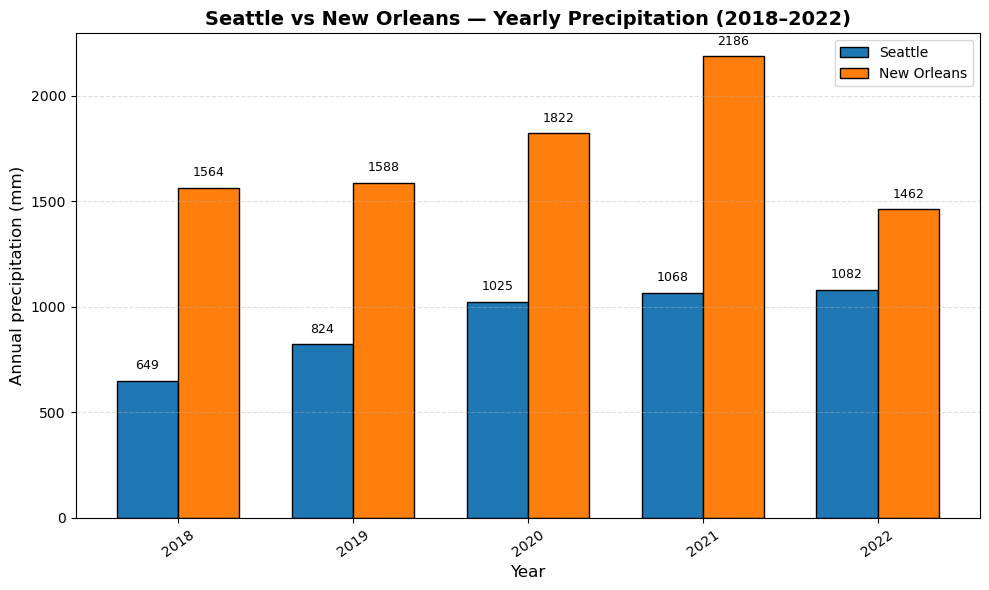

In [12]:
# --- Seattle vs New Orleans (2018-2022) — grouped bar chart ---
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# --- Adjust this if your Data folder is named differently ---
data_dir = os.path.join("..","Data")   # notebook is in Code/, Data is sibling folder

seattle_fp = os.path.join(data_dir, "seattle_rain.csv")
no_fp      = os.path.join(data_dir, "neworleans_rain.csv")

# quick check: list files so you can confirm the paths
print("Files in Data folder:", sorted(os.listdir(data_dir)))

# --- load CSVs (will error with a clear message if file missing) ---
if not os.path.exists(seattle_fp):
    raise FileNotFoundError(f"Seattle file not found: {seattle_fp}")
if not os.path.exists(no_fp):
    raise FileNotFoundError(f"New Orleans file not found: {no_fp}")

seattle = pd.read_csv(seattle_fp)
neworleans = pd.read_csv(no_fp)

# --- clean column names (strip whitespace) ---
seattle.columns = seattle.columns.str.strip()
neworleans.columns = neworleans.columns.str.strip()

print("\nSeattle columns:", list(seattle.columns))
print("New Orleans columns:", list(neworleans.columns))

# --- find date column (common names) ---
def find_date_col(df):
    for c in df.columns:
        if c.strip().upper() == 'DATE' or 'DATE' in c.strip().upper():
            return c
    for c in df.columns:
        if 'YEAR' in c.strip().upper() and df[c].dtype == object:
            return c
    return None

date_col_s = find_date_col(seattle)
date_col_n = find_date_col(neworleans)
if date_col_s is None or date_col_n is None:
    raise KeyError("Couldn't find a DATE column in one of the files. Check printed column lists above.")

# parse dates and extract year
seattle['DATE_parsed'] = pd.to_datetime(seattle[date_col_s], errors='coerce', infer_datetime_format=True)
neworleans['DATE_parsed'] = pd.to_datetime(neworleans[date_col_n], errors='coerce', infer_datetime_format=True)
seattle['Year'] = seattle['DATE_parsed'].dt.year
neworleans['Year'] = neworleans['DATE_parsed'].dt.year

# --- find precipitation column (robust search) ---
def find_prcp_col(df):
    for c in df.columns:
        cu = c.strip().upper()
        if cu.startswith('PRCP') or 'PRECIP' in cu or cu == 'PRCP':
            return c
    # fallback: first numeric column that is not obviously snow- or wind-related
    numeric = df.select_dtypes(include='number').columns.tolist()
    for n in numeric:
        if n.upper() not in ('SNOW','SNWD','WESD','WESF'):
            return n
    return None

sea_prcp = find_prcp_col(seattle)
no_prcp  = find_prcp_col(neworleans)
if sea_prcp is None or no_prcp is None:
    raise KeyError("Couldn't find precipitation column in one of the files. Check column lists above.")

print("\nUsing precipitation columns -> Seattle:", sea_prcp, "| New Orleans:", no_prcp)

# --- compute yearly totals for 2018-2022 ---
YEARS = [2018,2019,2020,2021,2022]

sea_yearly = (seattle.dropna(subset=['Year'])
                      .groupby('Year')[sea_prcp]
                      .sum()
                      .reindex(YEARS)
                      .fillna(0)
                      .reset_index()
                      .rename(columns={sea_prcp: 'Seattle_total'}))

no_yearly  = (neworleans.dropna(subset=['Year'])
                      .groupby('Year')[no_prcp]
                      .sum()
                      .reindex(YEARS)
                      .fillna(0)
                      .reset_index()
                      .rename(columns={no_prcp: 'NewOrleans_total'}))

print("\nSeattle yearly totals (raw):")
print(sea_yearly)
print("\nNew Orleans yearly totals (raw):")
print(no_yearly)

# --- unit heuristic: convert to millimeters if yearly means look small ---
def maybe_convert_to_mm(df, colname, city):
    mean_val = df[colname].mean()
    if mean_val < 100:  # heuristic: if small numbers, assume inches and convert
        df[colname + "_mm"] = df[colname] * 25.4
        converted = True
    else:
        df[colname + "_mm"] = df[colname]
        converted = False
    print(f"{city}: mean={mean_val:.2f} -> converted_to_mm={converted}")
    return df

sea_year = maybe_convert_to_mm(sea_yearly, 'Seattle_total', 'Seattle')
no_year  = maybe_convert_to_mm(no_yearly,  'NewOrleans_total', 'New Orleans')

# --- prepare values for plotting ---
years = sea_year['Year'].tolist()  # [2018..2022]
sea_vals = sea_year['Seattle_total_mm'].values
no_vals  = no_year['NewOrleans_total_mm'].values

# --- plotting: grouped bar chart ---
x = np.arange(len(years))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

# Colors chosen to stand out
color_sea = '#1f77b4'   # blue
color_no  = '#ff7f0e'   # orange

bars1 = ax.bar(x - width/2, sea_vals, width, label='Seattle', color=color_sea, edgecolor='black')
bars2 = ax.bar(x + width/2, no_vals,  width, label='New Orleans', color=color_no,  edgecolor='black')

# Labels and title
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Annual precipitation (mm)', fontsize=12)
ax.set_title('Seattle vs New Orleans — Yearly Precipitation (2018–2022)', fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(years, rotation=35)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Add values above bars
def annotate_bars(bars):
    for b in bars:
        h = b.get_height()
        if np.isnan(h):
            continue
        ax.annotate(f"{h:.0f}", xy=(b.get_x() + b.get_width() / 2, h),
                    xytext=(0,6), textcoords="offset points", ha='center', va='bottom', fontsize=9)

annotate_bars(bars1)
annotate_bars(bars2)

# Legend and layout
ax.legend()
plt.tight_layout()

# Save high-resolution image to Reports/
reports_dir = os.path.join("..","Reports")
os.makedirs(reports_dir, exist_ok=True)
outpath = os.path.join(reports_dir, "seattle_vs_neworleans_bars.png")
plt.savefig(outpath, dpi=300)
print("\nSaved plot to:", outpath)

plt.show()

In [ ]:
# --- Solid Color Bar Chart: Seattle vs New Orleans (2018-2022) ---
import numpy as np
import matplotlib.pyplot as plt
import os

years = sea_year['Year'].tolist()
sea_vals = sea_year['Seattle_total_mm'].values
no_vals  = no_year['NewOrleans_total_mm'].values

x = np.arange(len(years))
width = 0.35

fig, ax = plt.subplots(figsize=(10,6))

# Solid colors: Teal + Pink
color_sea = '#17becf'   # Teal
color_no  = '#e377c2'   # Pink

bars1 = ax.bar(x - width/2, sea_vals, width, label='Seattle',
               color=color_sea, edgecolor='k')
bars2 = ax.bar(x + width/2, no_vals,  width, label='New Orleans',
               color=color_no, edgecolor='k')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Annual precipitation (mm)', fontsize=12)
ax.set_title('Seattle vs New Orleans — Yearly Precipitation (2018–2022)',
             fontsize=14, weight='bold')
ax.set_xticks(x)
ax.set_xticklabels(years, rotation=35)
ax.grid(axis='y', linestyle='--', alpha=0.4)

# Annotate values on bars
def annotate(bars):
    for b in bars:
        h = b.get_height()
        ax.annotate(f"{h:.0f}", xy=(b.get_x()+b.get_width()/2, h),
                    xytext=(0,5), textcoords="offset points",
                    ha='center', fontsize=9)
annotate(bars1)
annotate(bars2)

ax.legend()
plt.tight_layout()

# Save high-resolution image
reports_dir = os.path.join("..","Reports")
os.makedirs(reports_dir, exist_ok=True)
outpath = os.path.join(reports_dir, "seattle_vs_neworleans_bars_tealpink.png")
plt.savefig(outpath, dpi=300)
print("Saved plot to:", outpath)

plt.show()